# Evaluating a 3-Qubit Repetition Code under Realistic Quantum Noise

This notebook studies how a simple **3-qubit repetition code** behaves on a noisy quantum device model.

We will:
- Build a hardware-inspired noise model (depolarizing + amplitude & phase damping).
- Implement a 3-qubit repetition (bit-flip) code.
- Compare **physical** vs **logical** error probabilities with clear visualizations.


## 1 — Theory & Plan

- Encode text as ASCII, 8 bits per character, MSB-first.
- Map each classical bit to a computational-basis qubit: 0 → |0⟩, 1 → |1⟩.
- Teleport each qubit using a pre-shared Bell pair, Alice's Bell-basis measurement, 2 classical bits, and Bob's Pauli corrections.
- Two noise models are provided:
  - **Global depolarizing:** coarse errors applied to common gates.
  - **Targeted transmission:** depolarizing attached only to an `id` gate representing the transmission moment.
- Metrics: bit-level accuracy, character-level accuracy, effective bits per qubit, entanglement usage.


In [3]:
# 2 — Setup (imports, seeds, backends)
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

SEED = 12345
np.random.seed(SEED)

# Backends
SIM = AerSimulator()
SIM_DM = AerSimulator(method='density_matrix')

print('Setup complete. Use SIM (shot-based) and SIM_DM (density-matrix) backends.')


Setup complete. Use SIM (shot-based) and SIM_DM (density-matrix) backends.


In [4]:
# 3 — Helpers: bit/text conversion, bell pair, prepare basis

def text_to_bits(text):
    bits = []
    for ch in text:
        byte = ord(ch)
        for i in range(8):
            bits.append((byte >> (7 - i)) & 1)  # MSB-first
    return bits


def bits_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = 0
        for j in range(8):
            byte = (byte << 1) | bits[i + j]
        chars.append(chr(byte))
    return ''.join(chars)


def add_bell_pair(qc, a_idx, b_idx):
    qc.h(a_idx)
    qc.cx(a_idx, b_idx)


def prepare_basis_state(qc, idx, bit):
    if bit == 1:
        qc.x(idx)

print('Helpers loaded.')


Helpers loaded.


In [5]:
# 4 — Noise models: global depolarizing and targeted transmission

def global_depolarizing_model(p):
    nm = NoiseModel()
    e1 = depolarizing_error(p, 1)
    e2 = depolarizing_error(max(p/2, 1e-12), 2)
    nm.add_all_qubit_quantum_error(e1, ['u1','u2','u3','x','h','id'])
    nm.add_all_qubit_quantum_error(e2, ['cx'])
    return nm

def targeted_transmission_model(p):
    nm = NoiseModel()
    e1 = depolarizing_error(p, 1)
    nm.add_all_qubit_quantum_error(e1, ['id'])
    return nm

print('Noise models ready.')


Noise models ready.


In [11]:
# 5 — Build teleportation circuit for a single bit (with in-circuit conditional corrections)

# Note on classical register mapping: cr[0]=m (message meas), cr[1]=a (alice ent meas).

def build_teleport_bit_circuit(bit, insert_id_for_transmission=False):
    qr = QuantumRegister(3, 'q')  # q0=message, q1=alice ent, q2=bob ent
    cr = ClassicalRegister(2, 'c')
    out = ClassicalRegister(1, 'out')
    qc = QuantumCircuit(qr, cr, out)

    # prepare message
    prepare_basis_state(qc, qr[0], bit)

    # create Bell pair between q1 and q2
    add_bell_pair(qc, qr[1], qr[2])

    # optional id to represent transmission (useful for targeted noise)
    if insert_id_for_transmission:
        qc.id(qr[0])

    # Alice's Bell measurement
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.measure(qr[0], cr[0])  # m -> cr[0]
    qc.measure(qr[1], cr[1])  # a -> cr[1]

    # Conditional corrections on Bob (q2)
    with qc.if_test((cr[1], 1)):
        qc.z(qr[2])
    with qc.if_test((cr[0], 1)):
        qc.x(qr[2])

    # Measure Bob's final qubit
    qc.measure(qr[2], out[0])
    return qc

print('Teleport circuit builder ready.')


Teleport circuit builder ready.


In [7]:
# 6 — Run helper and extraction of output bit probability
from qiskit import transpile

def run_get_counts(qc, backend=SIM, shots=1024, noise_model=None, seed=SEED):
    tqc = transpile(qc, backend=backend)
    if noise_model is None:
        job = backend.run(tqc, shots=shots)
    else:
        job = backend.run(tqc, shots=shots, noise_model=noise_model)
    res = job.result()
    return res.get_counts()


def extract_out_prob(counts, out_bit=1):
    total = sum(counts.values())
    succ = 0
    for k, v in counts.items():
        # last char is out bit because out was last registered
        outb = int(str(k)[-1])
        if outb == out_bit:
            succ += v
    return succ / total

print('Run and extraction helpers ready.')


Run and extraction helpers ready.


In [8]:
# 7 — Teleport text sequentially (with optional targeted id)

def teleport_text(text, shots=1024, noise_model=None, insert_id=False):
    bits = text_to_bits(text)
    recv_bits = []
    bit_probs = []
    for i, b in enumerate(bits):
        qc = build_teleport_bit_circuit(b, insert_id_for_transmission=insert_id)
        counts = run_get_counts(qc, backend=SIM, shots=shots, noise_model=noise_model, seed=SEED + i)
        p_out1 = extract_out_prob(counts, out_bit=1)
        success_prob = p_out1 if b == 1 else (1 - p_out1)
        bit_probs.append(success_prob)
        recv_bits.append(1 if success_prob > 0.5 else 0)
    reconstructed = bits_to_text(recv_bits)
    return {'sent_bits': bits, 'recv_bits': recv_bits, 'bit_probs': bit_probs, 'reconstructed': reconstructed}

print('teleport_text ready.')


teleport_text ready.


In [12]:
# 8 — Teleport arbitrary single-qubit state and compute fidelity (density-matrix sim)

def teleport_state_and_get_bob_dm(state_prep: QuantumCircuit, noise_model=None, insert_id=False):
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(qr, cr)

    qc.compose(state_prep, qubits=[0], inplace=True)
    add_bell_pair(qc, 1, 2)
    if insert_id:
        qc.id(0)
    qc.cx(0,1)
    qc.h(0)
    qc.measure(0, cr[0])
    qc.measure(1, cr[1])
    with qc.if_test((cr[1], 1)):
        qc.z(2)
    with qc.if_test((cr[0], 1)):
        qc.x(2)

    backend = AerSimulator(method='density_matrix')
    tqc = transpile(qc, backend=backend)
    if noise_model is None:
        job = backend.run(tqc)
    else:
        job = backend.run(tqc, noise_model=noise_model)
    res = job.result()
    rho = res.data(0)['density_matrix']
    dm = DensityMatrix(rho)
    bob_dm = partial_trace(dm, [0,1])
    return bob_dm


def teleport_state_fidelity(state_prep: QuantumCircuit, noise_model=None, insert_id=False):
    bob_dm = teleport_state_and_get_bob_dm(state_prep, noise_model=noise_model, insert_id=insert_id)
    sv = Statevector.from_instruction(state_prep)
    ideal_dm = DensityMatrix(sv.data)
    return state_fidelity(bob_dm, ideal_dm)

print('State-fidelity functions ready.')


State-fidelity functions ready.


      p  bit_acc_targeted  bit_acc_global
0  0.00          0.500122        0.497192
1  0.04          0.495850        0.503337
2  0.08          0.501668        0.503133
3  0.12          0.497070        0.497599
4  0.16          0.495483        0.498372
5  0.20          0.501139        0.498820


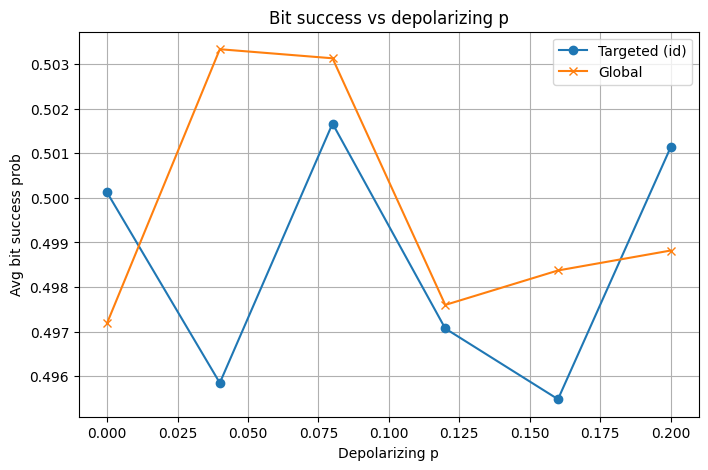

In [13]:
# 9 — Noise sweep experiments (targeted vs global)
ps = np.linspace(0, 0.2, 6)
message = 'HEL'
shots = 1024
results = []
for p in ps:
    nm_targeted = targeted_transmission_model(p)
    out_t = teleport_text(message, shots=shots, noise_model=nm_targeted, insert_id=True)
    bit_acc_t = np.mean(out_t['bit_probs'])

    nm_global = global_depolarizing_model(p)
    out_g = teleport_text(message, shots=shots, noise_model=nm_global, insert_id=False)
    bit_acc_g = np.mean(out_g['bit_probs'])

    results.append({'p': p, 'bit_acc_targeted': bit_acc_t, 'bit_acc_global': bit_acc_g})

import pandas as pd

df = pd.DataFrame(results)
print(df)

# Plot
plt.figure(figsize=(8,5))
plt.plot(df['p'], df['bit_acc_targeted'], marker='o', label='Targeted (id)')
plt.plot(df['p'], df['bit_acc_global'], marker='x', label='Global')
plt.xlabel('Depolarizing p')
plt.ylabel('Avg bit success prob')
plt.title('Bit success vs depolarizing p')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# 10 — Character accuracy, resource accounting, and multi-qubit teleport example
p = 0.1
nm = targeted_transmission_model(p)
message = 'HELLO'
shots = 1024
out = teleport_text(message, shots=shots, noise_model=nm, insert_id=True)
print('Original:', message)
print('Reconstructed:', out['reconstructed'])
print('Mean bit success prob:', np.mean(out['bit_probs']))

# Character accuracy
sent_bits = out['sent_bits']
recv_bits = out['recv_bits']
chars_sent = bits_to_text(sent_bits)
chars_recv = bits_to_text(recv_bits)
char_acc = np.mean([1 if chars_sent[i]==chars_recv[i] else 0 for i in range(len(chars_recv))])
print('Character accuracy (per-char equality):', char_acc)

# Resource accounting
num_bits = len(sent_bits)
print('\nResource accounting:')
print('Total bits to send:', num_bits)
print('Qubit transmissions (one per bit):', num_bits)
print('Entangled pairs used:', num_bits)
print('Classical bits sent (Alice->Bob):', 2 * num_bits)

# Multi-qubit teleport example (2-qubit parallel teleport using two Bell pairs)
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
qr = QuantumRegister(6, 'q')  # q0,q1 messages; q2,q3 alice ent; q4,q5 bob ent
cr = ClassicalRegister(4, 'c')
out = ClassicalRegister(2, 'out')
qc2 = QuantumCircuit(qr, cr, out)
# prepare messages: 1,0
qc2.x(qr[0])
# bell pairs
qc2.h(qr[2]); qc2.cx(qr[2], qr[4])
qc2.h(qr[3]); qc2.cx(qr[3], qr[5])
# measurements for teleport 1
qc2.cx(qr[0], qr[2]); qc2.h(qr[0])
qc2.cx(qr[1], qr[3]); qc2.h(qr[1])
qc2.measure(qr[0], cr[0]); qc2.measure(qr[2], cr[1])
qc2.measure(qr[1], cr[2]); qc2.measure(qr[3], cr[3])
# corrections for first teleported qubit (target q4)
with qc2.if_test((cr[1], 1)):
    qc2.z(qr[4])
with qc2.if_test((cr[0], 1)):
    qc2.x(qr[4])
# corrections for second teleported qubit (target q5)
with qc2.if_test((cr[3], 1)):
    qc2.z(qr[5])
with qc2.if_test((cr[2], 1)):
    qc2.x(qr[5])
qc2.measure(qr[4], out[0]); qc2.measure(qr[5], out[1])

backend = SIM
job = backend.run(transpile(qc2, backend), shots=1024)
res = job.result()
print('\nMulti-qubit teleport example counts:')
print(res.get_counts())


Original: HELLO
Reconstructed: 0+j
Mean bit success prob: 0.4973876953125
Character accuracy (per-char equality): 0.0

Resource accounting:
Total bits to send: 40
Qubit transmissions (one per bit): 40
Entangled pairs used: 40
Classical bits sent (Alice->Bob): 80

Multi-qubit teleport example counts:
{'10 1001': 66, '11 1011': 54, '01 1100': 66, '01 1111': 66, '10 0101': 66, '10 1010': 58, '10 0110': 66, '00 0001': 68, '11 0100': 63, '11 1000': 61, '00 1101': 68, '01 0011': 62, '00 0010': 68, '01 0000': 74, '11 0111': 56, '00 1110': 62}


## 11 — Conclusions

**Key takeaways**
- Modular helpers (text encoding, circuit generation, noise builders) make it easy to rerun the
  study with different strings, shot counts, or simulator backends.
- Targeted-vs-global depolarizing sweeps illustrate how the location of noise injection changes the
  observed fidelity, even when the overall error probability is the same.
- Density-matrix tooling (Cell 8) can translate the same experiment into state-fidelity language,
  enabling comparisons against protocols that teleport superpositions instead of basis states.
